In [1]:
#!/usr/bin/env python3.6
# -*- coding: utf-8 -*-

In [2]:
# Imports
import sys
import joblib
import numpy as np
from math import atan2
from matplotlib import animation
from IPython.display import HTML
from matplotlib import pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3

In [3]:
#np.random.seed(20)
np.set_printoptions(threshold=sys.maxsize)

In [4]:
%matplotlib inline

In [5]:
%store -r X_motion_CoM_acceleration
%store -r Y_motion_CoM_acceleration
print(X_motion_CoM_acceleration.shape)
print(Y_motion_CoM_acceleration.shape)

(7395, 23)
(7395, 3)


In [6]:
X_motion_CoM_acceleration[0]

array([0.1, 0.0, 0.0, 0.1, 0.0, 0.0, -0.00392833860457, 0.0159176796696,
       -0.00429879158561, 0.2526783703469499, 0.13427893772863944,
       -0.2778846068029694, 0.24869912614405365, -0.12366310216804982,
       -0.3133057085330896, -0.2690074673240338, 0.1271401124419832,
       -0.3136605626775182, -0.26988041665563206, -0.1350023534415291,
       -0.2815400304417422, False, True], dtype=object)

In [7]:
Y_motion_CoM_acceleration[0:100]

array([[0.015024544741364753, 0.0031745505499044297, 0],
       [0.0244901497177486, -0.0017141485288042285, 0],
       [0.023807360577614352, 0.0016117138856960357, 0],
       [0.028454635884038584, -0.0011932863192845068, 0],
       [0.02304735004324249, 0.001088606590820374, 0],
       [0.02424454757067094, -0.0013822147255968858, 0],
       [0.02857265080483277, 0.0013207193610095857, 0],
       [0.023672292991041486, -0.0011615224015968967, 0],
       [0.024427038629548616, 0.0012020538703732967, 0],
       [0.02405386268534631, -0.0013037454011880095, 0],
       [0.02807375693924579, 0.001285793776076903, 0],
       [0.023506903529684358, -0.0010863303010825438, 0],
       [0.023984797743990538, 0.0012408587464879553, 0],
       [0.02361076966462593, -0.0011992096455204074, 0],
       [0.028030238290395713, 0.0012099079529472188, 0],
       [0.02435197496686631, -0.0011986507148551457, 0],
       [0.022753119041687354, 0.0014287628521740627, 0],
       [0.02796312128603495, -0.00

# Multivariate Linear Regression (CoM Prediction)

In [8]:
import sklearn
from sklearn import metrics
from sklearn.feature_selection import RFE
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures 
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [9]:
idx_fr_rl_swinging = np.where(X_motion_CoM_acceleration[:, -1] == 1)[0]
X_motion_CoM_acceleration_FR_RL = X_motion_CoM_acceleration[idx_fr_rl_swinging]
Y_motion_CoM_acceleration_FR_RL = Y_motion_CoM_acceleration[idx_fr_rl_swinging]
print(X_motion_CoM_acceleration_FR_RL.shape)
print(Y_motion_CoM_acceleration_FR_RL.shape)

(3697, 23)
(3697, 3)


## Predict CoM (x) movement

In [10]:
X_motion_CoM_acceleration_FR_RL[0, :]

array([0.1, 0.0, 0.0, 0.1, 0.0, 0.0, -0.00392833860457, 0.0159176796696,
       -0.00429879158561, 0.2526783703469499, 0.13427893772863944,
       -0.2778846068029694, 0.24869912614405365, -0.12366310216804982,
       -0.3133057085330896, -0.2690074673240338, 0.1271401124419832,
       -0.3136605626775182, -0.26988041665563206, -0.1350023534415291,
       -0.2815400304417422, False, True], dtype=object)

In [11]:
Y_motion_CoM_acceleration_FR_RL[0, :]

array([0.015024544741364753, 0.0031745505499044297, 0], dtype=object)

### Linear Regression

In [12]:
def find_best_model(X, Y, runs=1000):
    best_model = None
    lowest_error = 100
    best_Xtr, best_Xte, best_Ytr, best_Yte = None, None, None, None
    
    for _ in range(runs):
        X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.9, shuffle=True)
        
        model = LinearRegression()
        model.fit(X_train, Y_train)

        predictions = model.predict(X_test)
        error = np.max(np.abs(predictions - Y_test))

        if error < lowest_error:
            best_model = model
            lowest_error = error
            best_Xtr, best_Xte, best_Ytr, best_Yte = X_train, X_test, Y_train, Y_test

    # Stats
    predictions = best_model.predict(best_Xte)
    print('R2: ', r2_score(predictions, best_Yte))
    print('RMSE: ', np.sqrt(mean_squared_error(best_Yte, predictions)))
    print("The lowest error is: ", np.min(np.abs(predictions - best_Yte)))
    print("The highest error is: ", np.max(np.abs(predictions - best_Yte)))
    print("The avg. error is: ", np.mean(np.abs(predictions - best_Yte)))
    
    return best_Xte, best_Yte, predictions, best_model

In [13]:
# Input
X = np.hstack((X_motion_CoM_acceleration_FR_RL[:, 0:1], # previous reference velocity
               X_motion_CoM_acceleration_FR_RL[:, 3:4], # current reference velocity
               X_motion_CoM_acceleration_FR_RL[:, 6:7], # actual velocity
               X_motion_CoM_acceleration_FR_RL[:, 9:11], # FL position
               X_motion_CoM_acceleration_FR_RL[:, 12:14], # FR position
               X_motion_CoM_acceleration_FR_RL[:, 15:17], # RL position
               X_motion_CoM_acceleration_FR_RL[:, 18:20])) # RR position

# Labels
Y = np.array([Y_motion_CoM_acceleration_FR_RL[:, 0]]).T

assert Y.shape[0] == X.shape[0]

# Split dataset and fit best model
X_test, Y_test, predictions, model_fr_com_x = find_best_model(X, Y, runs=5000)

R2:  0.9915745940309738
RMSE:  0.007680466870028681
The lowest error is:  2.6805912764493733e-07
The highest error is:  0.022262411156761808
The avg. error is:  0.006026830028975579


In [14]:
model_fr_com_x.coef_

array([[ 0.26798353,  0.1411866 ,  0.0034254 , -0.26421108, -0.12315839,
        -0.15470753, -0.58805423,  0.44947799,  0.27569299, -0.46356286,
         0.375402  ]])

In [15]:
model_fr_com_x.intercept_

array([0.05782257])

Text(0, 0.5, 'Predictions')

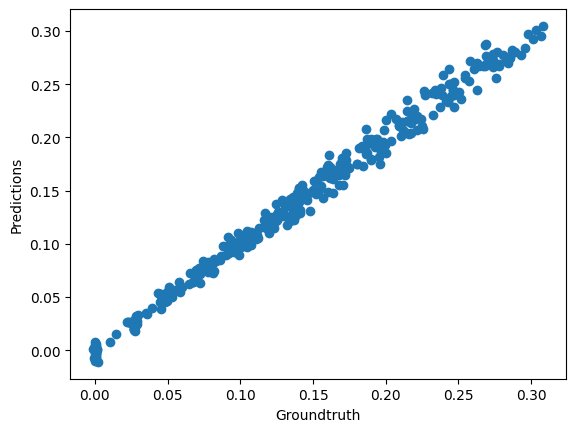

In [16]:
## The line / model
plt.scatter(Y_test, predictions)
plt.xlabel("Groundtruth")
plt.ylabel("Predictions")

In [17]:
for idx, prediction in enumerate(predictions):
    print(f'Groundtruth: {Y_test[idx]}. Predicted: {prediction}')

Groundtruth: [0.07425328189214499]. Predicted: [0.08396342]
Groundtruth: [0.027341183342918723]. Predicted: [0.02496843]
Groundtruth: [0.27386990981816334]. Predicted: [0.2783685]
Groundtruth: [0.17271198525365566]. Predicted: [0.18525355]
Groundtruth: [0.18697249810625632]. Predicted: [0.19850094]
Groundtruth: [0.02834147204877227]. Predicted: [0.02593898]
Groundtruth: [0.2382883429924493]. Predicted: [0.24672835]
Groundtruth: [0.1414045729375709]. Predicted: [0.14716957]
Groundtruth: [0.24126475647882906]. Predicted: [0.23439354]
Groundtruth: [-0.00011192222075165187]. Predicted: [-0.00753501]
Groundtruth: [0.13265350285518446]. Predicted: [0.12393638]
Groundtruth: [0.21443668261424367]. Predicted: [0.21562288]
Groundtruth: [0.026720564757241425]. Predicted: [0.01951781]
Groundtruth: [0.3084952924969258]. Predicted: [0.30479218]
Groundtruth: [0.21773689199054613]. Predicted: [0.22008431]
Groundtruth: [0.08653473434001131]. Predicted: [0.08870621]
Groundtruth: [0.23381737813957026]. P

## Predict CoM -> y

### Linear Regression

In [18]:
# Input
X = np.hstack((X_motion_CoM_acceleration_FR_RL[:, 0:1], # previous reference velocity
               X_motion_CoM_acceleration_FR_RL[:, 3:4], # current reference velocity
               X_motion_CoM_acceleration_FR_RL[:, 6:7], # actual velocity
               X_motion_CoM_acceleration_FR_RL[:, 9:11], # FL position
               X_motion_CoM_acceleration_FR_RL[:, 12:14], # FR position
               X_motion_CoM_acceleration_FR_RL[:, 15:17], # RL position
               X_motion_CoM_acceleration_FR_RL[:, 18:20])) # RR position

# Labels
Y = np.array([Y_motion_CoM_acceleration_FR_RL[:, 1]]).T

assert Y.shape[0] == X.shape[0]

# Split dataset and fit best model
X_test, Y_test, predictions, model_fr_com_y = find_best_model(X, Y, runs=5000)

R2:  0.9198778225132074
RMSE:  0.001641976290645314
The lowest error is:  5.37008427417573e-06
The highest error is:  0.00426687608550642
The avg. error is:  0.0012804781968983941


In [19]:
model_fr_com_y.coef_

array([[-0.02788519,  0.02285328,  0.00231819,  0.03030785,  0.03458423,
        -0.02304854,  0.02020893,  0.00394446, -0.0448641 , -0.01926709,
         0.06255304]])

In [20]:
model_fr_com_y.intercept_

array([0.00727056])

Text(0, 0.5, 'Predictions')

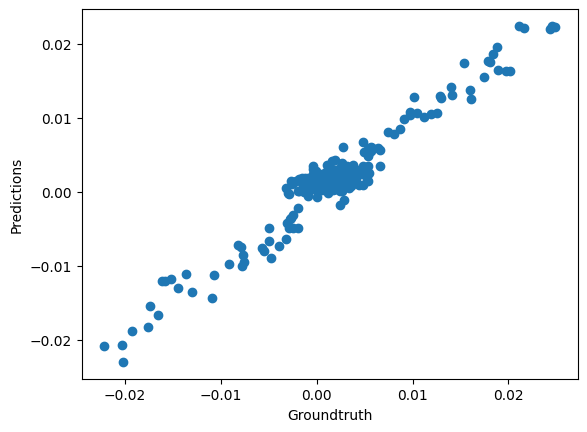

In [21]:
## The line / model
plt.scatter(Y_test, predictions)
plt.xlabel("Groundtruth")
plt.ylabel("Predictions")

In [22]:
#for idx, prediction in enumerate(predictions):
#    print(f'Groundtruth: {Y_test[idx]}. Predicted: {prediction}')